In [ ]:
import torch
import matplotlib.pyplot as plt 
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from torchvision.datasets import MNIST
from PIL import Image
import random
import IPython


num_epochs = 4
batch_size = 100
learning_rate = 0.2

# Image Preprocessing 

In [ ]:
class InColour(MNIST):
  def __init__(self, root, train=True, download=False, transform=False, target_transform= None):
    super(InColour, self).__init__(root, train=train, download=download, transform=transform, target_transform =target_transform)

  def __getitem__(self,index ):
    image, label = self.data[index], self.targets[index]
    image=  image.numpy()
    color =  (random.randint(0,255),random.randint(0,255),random.randint(0,255))
    image = np.stack((image,image,image), axis=2)
    image =  np.where(image>0, color, image)
    image= image.astype(np.uint8)
    image= Image.fromarray(image)

    if self.transform is not None:
        image = self.transform(image)
    if self.target_transform is not None:
        label = self.target_transform(label)
    #plot AND SHOW COLORED IMAGES
    return image, label

In [ ]:
transform = transforms.ToTensor()
train_dataset = InColour(root='./data', train=True, download=True, transform=transform)
test_dataset = InColour(root='./data', train=False, download=True, transform=transform)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/InColour/raw/train-images-idx3-ubyte.gz to ./data/InColour/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/InColour/raw/train-labels-idx1-ubyte.gz to ./data/InColour/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/InColour/raw/t10k-images-idx3-ubyte.gz to ./data/InColour/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/InColour/raw/t10k-labels-idx1-ubyte.gz to ./data/InColour/raw



In [ ]:
for i in range(len(train_dataset)):
    train_dataset.__getitem__(i)

device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [ ]:
class Encoder(nn.Module):
  def __init__(self, latent_dims):
    super(Encoder, self).__init__()
    self.latent_dims = latent_dims
    self.linear1 = nn.Linear(2352, 512)
    self.to_mean_logvar = nn.Linear(512, 2*latent_dims)

  def reparametrization_trick(self, mu, log_var):
    # Using reparameterization trick to sample from a gaussian
    eps = torch.randn_like(log_var)
    return mu + torch.exp(log_var / 2) * eps

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = F.relu(self.linear1(x))
    mu, log_var = torch.split(self.to_mean_logvar(x),self.latent_dims, dim=-1)
    self.kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return self.reparametrization_trick(mu, log_var)


class Decoder(nn.Module):
  def __init__(self, latent_dims):
    super(Decoder, self).__init__()
    self.linear1 = nn.Linear(latent_dims, 512)
    self.linear2 = nn.Linear(512, 2352)
  def forward(self, z):
    z = F.relu(self.linear1(z))
    z = torch.sigmoid(self.linear2(z))
    return z.reshape((-1, 3, 28, 28))


class VariationalAutoencoder(nn.Module):
  def __init__(self, latent_dims):
    super().__init__()
    self.encoder = Encoder(latent_dims)
    self.decoder = Decoder(latent_dims)

  def forward(self, x):
    z = self.encoder(x)
    return self.decoder(z)

In [ ]:
def train(vae, data, epochs=20):
  opt = torch.optim.Adam(vae.parameters(), lr = 0.001)
  train_loss =0.0
  for epoch in range(epochs):
    train_loss =0.0
    print(f'Epoch {epoch + 1}')
    for x, y in data:
        x = x.to(device) # GPU
        opt.zero_grad()
        x_hat = vae(x)
        loss = F.binary_cross_entropy(x_hat, x, reduction='sum') + vae.encoder.kl
        train_loss += loss.item()
        loss.backward()
        opt.step()
    print(f"The Epoch loss is: {train_loss} \n")


  return vae  

def plot_latent(autoencoder, data, num_batches=100):
  for i, (x, y) in enumerate(data):
    z = autoencoder.encoder(x.to(device))
    z = z.to('cpu').detach().numpy()
    plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
    if i > num_batches:
      plt.colorbar()
      plt.show()
      break

def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
  w = 28
  img = []
  for i, z2 in enumerate(np.linspace(r1[1],r1[0], n)):
    for j, z1 in enumerate(np.linspace(*r0, n)):
      z = torch.Tensor([[z1, z2]]).to(device)
      x_hat = autoencoder.decoder(z)
      img.append(x_hat)

  img = torch.cat(img)
  img = torchvision.utils.make_grid(img,nrow=12).permute(1, 2, 0).detach()
  plt.imshow(img.cpu(),extent=[*r0, *r1])


Epoch 1
The Epoch loss is: 31118840.59375 

Epoch 2
The Epoch loss is: 28914591.96484375 

Epoch 3
The Epoch loss is: 28533887.71484375 

Epoch 4
The Epoch loss is: 28344636.1875 

Epoch 5
The Epoch loss is: 28228233.4375 

Epoch 6
The Epoch loss is: 28156643.515625 

Epoch 7
The Epoch loss is: 28082214.84765625 

Epoch 8
The Epoch loss is: 27996816.62109375 

Epoch 9
The Epoch loss is: 27921943.90234375 

Epoch 10
The Epoch loss is: 27869392.25 

Epoch 11
The Epoch loss is: 27820293.3515625 

Epoch 12
The Epoch loss is: 27802962.23828125 

Epoch 13
The Epoch loss is: 27744244.26953125 

Epoch 14
The Epoch loss is: 27704676.53515625 

Epoch 15
The Epoch loss is: 27658548.62890625 

Epoch 16
The Epoch loss is: 27632570.6328125 

Epoch 17
The Epoch loss is: 27598216.5546875 

Epoch 18
The Epoch loss is: 27552665.53515625 

Epoch 19
The Epoch loss is: 27554845.48046875 

Epoch 20
The Epoch loss is: 27530295.80078125 



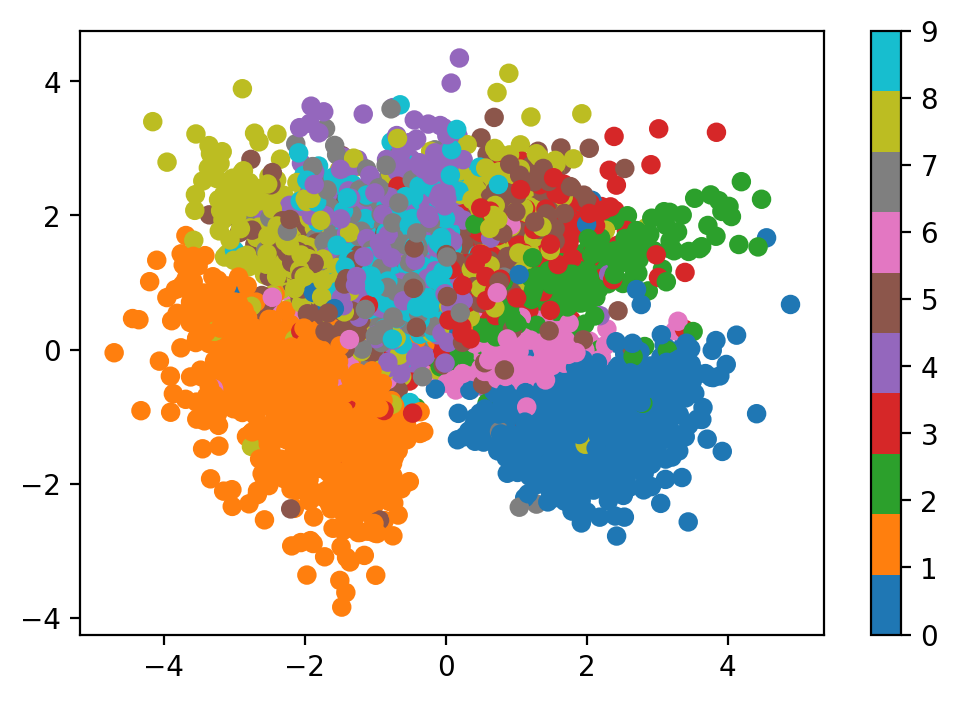

In [ ]:
z_dim=2
vae = VariationalAutoencoder(z_dim).to(device)
vae = train(vae, train_loader, epochs=20)
plot_latent(vae, train_loader)

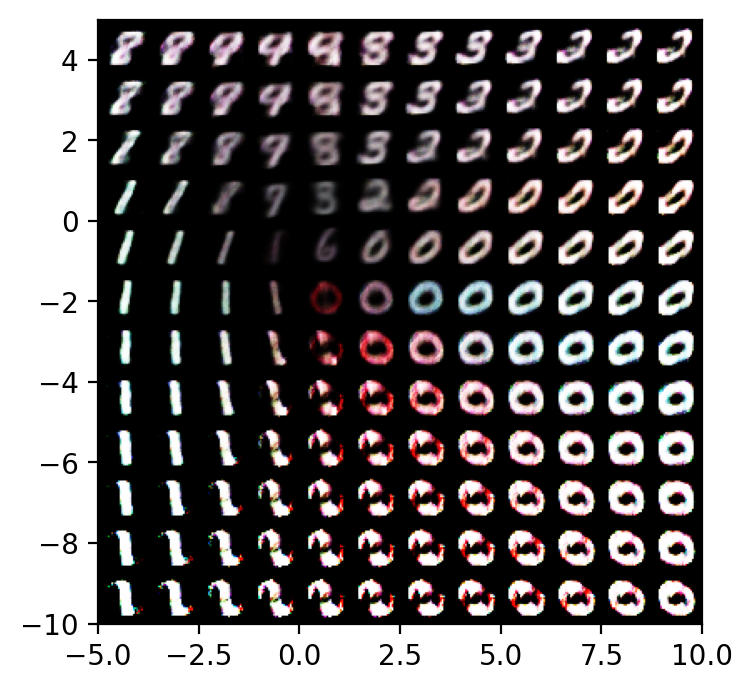

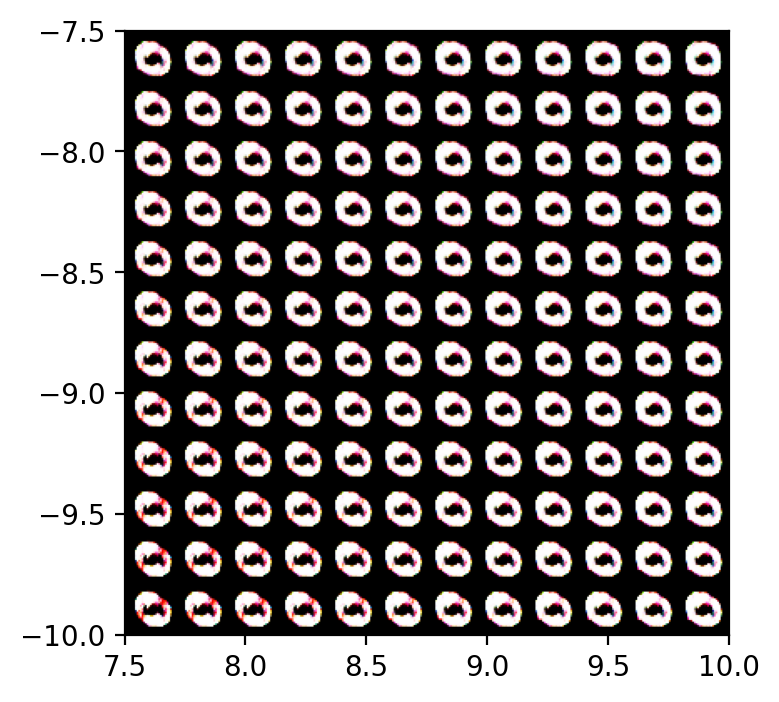

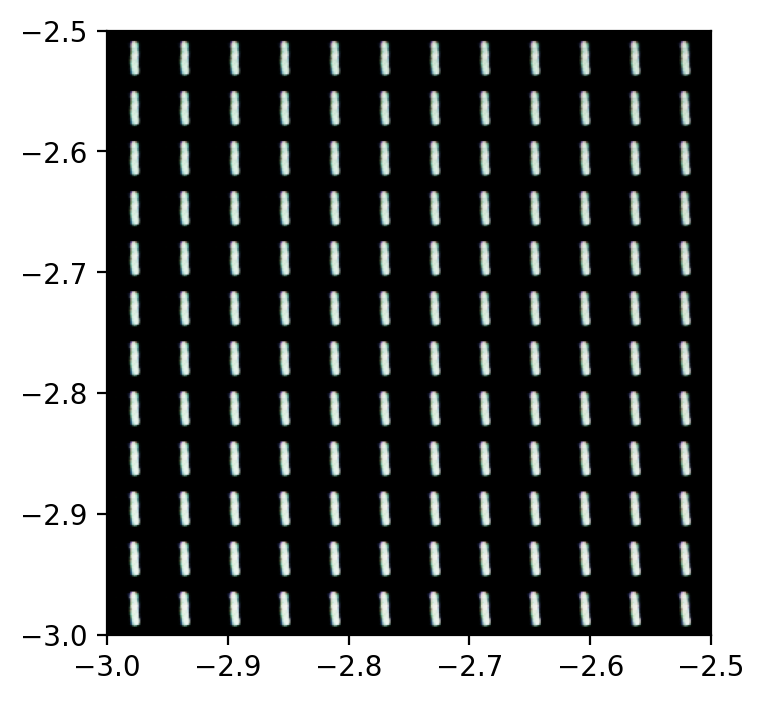

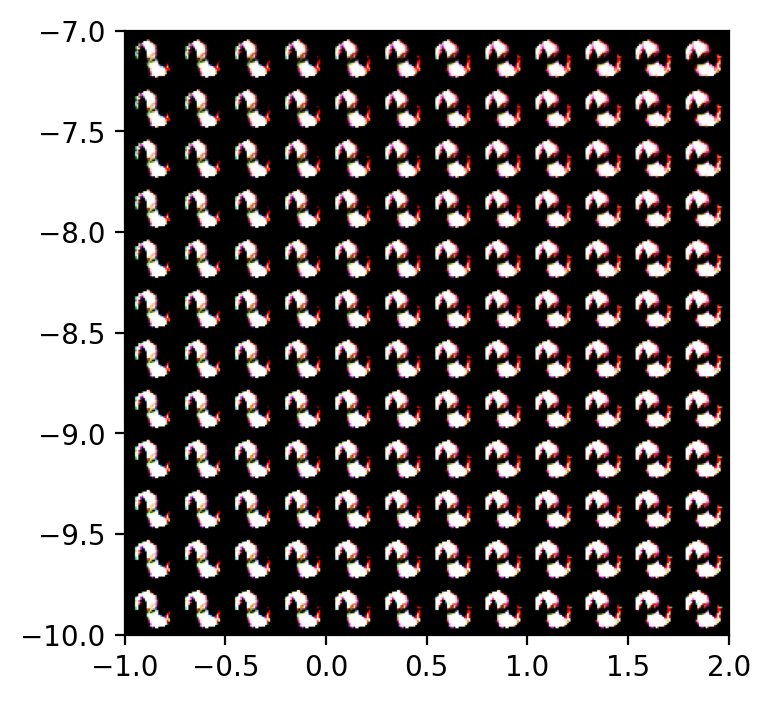

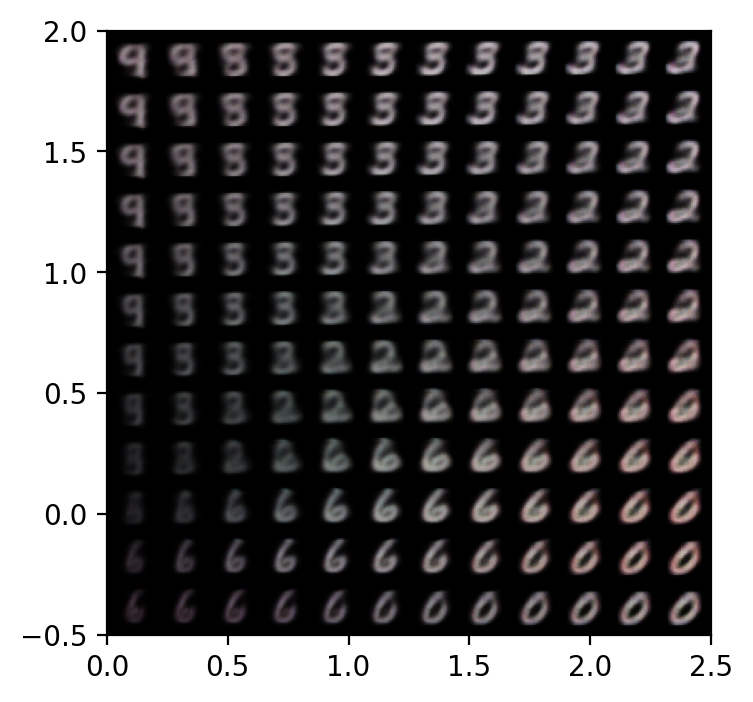

In [ ]:
plot_reconstructed(vae, r0=(-5, 10), r1=(-10, 5), n=12)
plt.show()
plot_reconstructed(vae,  r0=(7.5, 10), r1=(-10, -7.5), n=12)#zero
plt.show()
plot_reconstructed(vae,  r0=(-3, -2.5), r1=(-3, -2.5), n=12)#one
plt.show()
plot_reconstructed(vae,  r0=(-1, 2), r1=(-10, -7), n=12)#two
plt.show()
plot_reconstructed(vae,  r0=(0, 2.5), r1=(-0.5, 2), n=12)#two
plt.show()


In [ ]:
torch.save(vae.state_dict(), 'continous_vae.pkl')


***Discrete*** (categorical) VAE


In [ ]:
def sample_gumbel(shape, eps=1e-20):
    #Sample from Gumbel(0, 1)
    U = torch.rand(shape).float()
    return - torch.log(eps - torch.log(U + eps))

def gumbel_softmax_sample(logits, tau=1, eps=1e-20):    
    dims = len(logits.size())
    gumbel_noise = sample_gumbel(logits.size(), eps=eps).to(device)
    y = logits + gumbel_noise
    return F.softmax(y / tau, dim=-1)

def gumbel_softmax(logits, tau=1, hard=False, eps=1e-10):

    bs, N,K = logits.size()    
    y_soft = gumbel_softmax_sample(logits.view(bs*N,K), tau=tau, eps=eps)
    if hard:
        k = torch.argmax(y_soft, dim=-1)
        y_hard = F.one_hot(k, num_classes=K)

        # 1. makes the output value exactly one-hot
        # 2.makes the gradient equal to y_soft gradient
        y = y_hard - y_soft.detach() + y_soft
    else:
        y = y_soft
        
    return y.reshape(bs, N*K).to(device)

In [ ]:
class DiscreteVAE(nn.Module):
    def __init__(self, latent_dim, categorical_dim):
        super(DiscreteVAE, self).__init__()

        self.fc1 = nn.Linear(2352, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, latent_dim * categorical_dim)

        self.fc4 = nn.Linear(latent_dim * categorical_dim, 256)
        self.fc5 = nn.Linear(256, 512)
        self.fc6 = nn.Linear(512, 2352)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        self.N = latent_dim
        self.K = categorical_dim
        
    def encoder(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        return self.relu(self.fc3(h2))

    def decoder(self, z):
        h4 = self.relu(self.fc4(z))
        h5 = self.relu(self.fc5(h4))
        return self.sigmoid(self.fc6(h5))

    def forward(self, x, temp, hard):
        q = self.encoder(x.view(-1, 2352).to(device))
        q_y = q.view(q.size(0), self.N, self.K)
        z = gumbel_softmax(q_y, temp, hard)
        return self.decoder(z), F.softmax(q_y, dim=-1).reshape(q.size(0)*self.N, self.K)

In [ ]:
N = 3
K = 20  # one-of-K vector

temp = 1.0
hard = False
temp_min = 0.5
ANNEAL_RATE = 0.00003

model = DiscreteVAE(N, K).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, qy):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 2352).to(device), reduction='sum') / x.shape[0]

    log_ratio = torch.log(qy * qy.size(-1) + 1e-20)
    KLD = torch.sum(qy * log_ratio, dim=-1).mean()

    return BCE + KLD


def train(num_epochs=20, temp=1.0, hard=False):
    model.train()
    train_loss = 0
    run_loss = 0.0
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}')
        run_loss = 0.0
        for batch_idx, (x, _) in enumerate(train_loader):
            optimizer.zero_grad()
            x_hat, qy = model(x, temp, hard)
            loss = loss_function(x_hat, x, qy) 
            train_loss += loss.item()
            loss.backward()
            train_loss += loss.item() * len(x)
            run_loss += loss.item()
            optimizer.step()
            if batch_idx % 100 == 1:
                temp = np.maximum(temp * np.exp(-ANNEAL_RATE * batch_idx), temp_min)
        print(f"Epoch loss is: {run_loss} \n")


In [ ]:
train(20, temp, hard)

Epoch 1
Epoch loss is: 330484.2967529297 

Epoch 2
Epoch loss is: 278574.1408996582 

Epoch 3
Epoch loss is: 252741.53802490234 

Epoch 4
Epoch loss is: 241453.89041137695 

Epoch 5
Epoch loss is: 236760.36660766602 

Epoch 6
Epoch loss is: 234601.65692138672 

Epoch 7
Epoch loss is: 232778.89068603516 

Epoch 8
Epoch loss is: 231907.8969116211 

Epoch 9
Epoch loss is: 230589.26272583008 

Epoch 10
Epoch loss is: 229725.84176635742 

Epoch 11
Epoch loss is: 228901.72973632812 

Epoch 12
Epoch loss is: 228474.39431762695 

Epoch 13
Epoch loss is: 227930.1535949707 

Epoch 14
Epoch loss is: 227534.40841674805 

Epoch 15
Epoch loss is: 227259.87335205078 

Epoch 16
Epoch loss is: 227120.94961547852 

Epoch 17
Epoch loss is: 226474.96966552734 

Epoch 18
Epoch loss is: 225657.85263061523 

Epoch 19
Epoch loss is: 225123.23825073242 

Epoch 20
Epoch loss is: 223977.02865600586 



In [ ]:
import IPython

ind = torch.zeros(N,1).long()
images_list = []
for k in range(K):
    to_generate = torch.zeros(K*K,N,K)
    index = 0
    for i in range(K):
        for j in range(K):

            ind[1]=k
            ind[0]=i
            ind[2]=j
            z = F.one_hot(ind, num_classes=K).squeeze(1)
            to_generate[index]=z
            index += 1

    generate = to_generate.view(-1,K*N)
    reconst_images= model.decoder(generate.to(device))
    reconst_images = reconst_images.view(reconst_images.size(0), 3, 28, 28).detach()    
    grid_img = torchvision.utils.make_grid(reconst_images.cpu(),nrow=K).permute(1, 2, 0).numpy() * 255
    grid_img = grid_img.astype(np.uint8)
    images_list.append(Image.fromarray(grid_img))


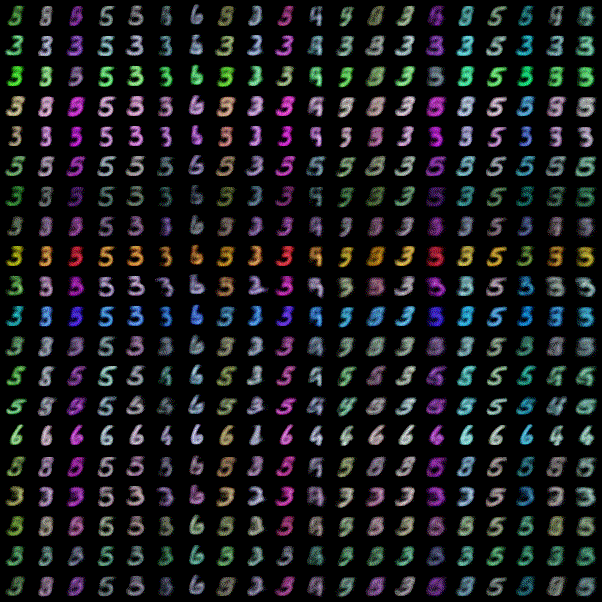

In [ ]:
images_list[0].save(
    'dvae.gif', 
    save_all=True,
    duration=700,
    append_images=images_list[1:],
    loop=10)
IPython.display.Image("dvae.gif", width=500, height=500)

In [ ]:
torch.save(model.state_dict(), 'DiscreteVAE.pkl')

**Joint VAE**

In [ ]:
class JointVAE(nn.Module):
  def __init__(self, latent_dim ,N,K):
    super(JointVAE, self).__init__()
    # Encoding
    self.fc1 = nn.Linear(2352, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc_to_d = nn.Linear(256, N * K)
    self.fc_to_n = nn.Linear(256, 2*latent_dim)

        

    # Decoding
    self.fc3 = nn.Linear(latent_dim + N*K, 256)
    self.fc4 = nn.Linear(256, 512)
    self.fc5 = nn.Linear(512, 2352)

    self.N = N
    self.K = K
    self.normal_latent_dim = latent_dim

    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def loss_function(self,recon_x, x, qy):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') / x.shape[0]

    log_ratio = torch.log(qy * qy.size(-1) + 1e-20)
    KLD = torch.sum(qy * log_ratio, dim=-1).mean()

    return BCE + KLD + self.encoder_normal.kl

  def reparametrization_trick(self, mu, log_var):
    # Using reparameterization trick to sample from a gaussian
    eps = torch.randn_like(log_var)
    return mu + torch.exp(log_var / 2) * eps

  def encoder_continuous(self, x):
    h1 = F.relu(self.fc1(x))
    h2 = F.relu(self.fc2(h1))
    h3 = self.fc_to_n(h2)
    mu, log_var = torch.split(h3,self.normal_latent_dim, dim=-1)
    self.kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    z = self.reparametrization_trick(mu, log_var)
    return z

  def encoder_discrete(self,x, temp, hard):
    h1 = self.relu(self.fc1(x))
    h2 = self.relu(self.fc2(h1))
    q =  self.relu(self.fc_to_d(h2))
    q_y = q.view(q.size(0), self.N, self.K)
    z = gumbel_softmax(q_y, temp, hard)
    return z, F.softmax(q_y, dim=-1).reshape(q.size(0)*self.N, self.K)

  def encoder_joint(self,x, temp, hard):
    input = x.view(-1, 2352)
    z_normal = self.encoder_continuous(input)
    z_discrete, qy = self.encoder_discrete(input, temp, hard)
    output = torch.cat((z_normal, z_discrete), dim = 1)
    return output, qy

  def decoder(self,x):
    output = F.relu(self.fc3(x))
    output = F.relu(self.fc4(output))
    output = self.sigmoid(self.fc5(output))
    # output = output.view(-1, 3,28,28)
    output = output.view(-1, 2352)
    return output

  def forward(self,input, temp, hard):
    x, qy = self.encoder_both(input, temp, hard)
    x = self.decoder(x)
    return x, qy


def train(model, num_epochs=20, temp=1.0, hard=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    model.train()
    train_loss = 0
    for epoch in range(num_epochs):
        print(f"Epoch: {epoch+1}")
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.to(device)
            optimizer.zero_grad()
            x_hat, qy = model(x, temp, hard)
            loss = loss_function(x_hat, x, qy)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            temp = np.maximum(temp * np.exp(-ANNEAL_RATE * batch_idx), temp_min)

        print(f"The Epochs loss is: {train_loss} \n")
        train_loss = 0.0

    return model

N = 1
K = 10
z_dim = 10
model = JointVAE(z_dim, N, K).to(device)
model = train(model,20)

Epoch: 1
Epochs loss: 266146.25762939453 

Epoch: 2
Epochs loss: 202331.49432373047 

Epoch: 3
Epochs loss: 194460.54388427734 

Epoch: 4
Epochs loss: 190746.58554077148 

Epoch: 5
Epochs loss: 188611.36288452148 

Epoch: 6
Epochs loss: 187403.18798828125 

Epoch: 7
Epochs loss: 186099.94778442383 

Epoch: 8
Epochs loss: 185046.83856201172 

Epoch: 9
Epochs loss: 184438.64385986328 

Epoch: 10
Epochs loss: 183780.16073608398 

Epoch: 11
Epochs loss: 183289.90313720703 

Epoch: 12
Epochs loss: 182543.29028320312 

Epoch: 13
Epochs loss: 182211.68188476562 

Epoch: 14
Epochs loss: 181859.77340698242 

Epoch: 15
Epochs loss: 181175.94375610352 

Epoch: 16
Epochs loss: 181125.58038330078 

Epoch: 17
Epochs loss: 180748.4786682129 

Epoch: 18
Epochs loss: 180450.45904541016 

Epoch: 19
Epochs loss: 180202.0805053711 

Epoch: 20
Epochs loss: 180026.96612548828 



In [ ]:
def joint_reconstruction(model, N,K,z_dim):
    images_list = []
    ind = torch.zeros(N,1).long()
    for k in range(K):
        to_generate = torch.zeros(K*K,N,K)
        index = 0
        z = F.one_hot(torch.tensor([k]), num_classes=K).squeeze(1)
        to_generate[index]= z
        index += 1

        generate = to_generate.view(-1,K*N).to(device)
        z_continuous = torch.normal(0, 5, size=(generate.shape[0], z_dim)).to(device)
        generate = torch.cat((z_continuous, generate), dim=1)
        reconst_images= model.decoder(generate)
        reconst_images = reconst_images.view(reconst_images.size(0), 3, 28, 28).detach().cpu() 
        grid_img = torchvision.utils.make_grid(reconst_images,nrow=K).permute(1, 2, 0).numpy() * 255
        grid_img = grid_img.astype(np.uint8)
        images_list.append(Image.fromarray(grid_img))

    return images_list

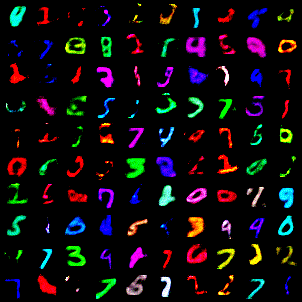

In [ ]:
images_list = joint_reconstruction(model, N,K,z_dim)

images_list[0].save(
'dvae.gif', 
save_all=True,
duration=500,
append_images=images_list[1:],
loop=1)
IPython.display.Image("dvae.gif", width=600, height=600)

In [ ]:
torch.save(model.state_dict(), 'JointVAE.pkl')
